# Processing chain _data science_. 
## _Classification_ with ‘python’ ([‘scipy’](https://www.scipy.org/), [‘scikit-learn’](https://scikit-learn.org/)) 


|Author|School|Modification| 
|---|---|---| 
|P. Halftermeyer|Orléans|2018/11/17| 

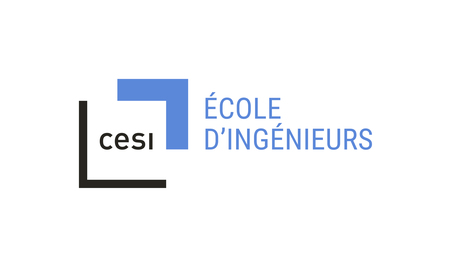

__Dependency__: This Notebook must be carried out after those on _data wrangling_ and _pipeline ML_. 

After studying a _regression_ problem, we’ll now focus on other major type of supervised _ML_ tasks, namely _classification_. 

# Setup

In [5]:
# To support both Python 2 and Python 3 
from __future__ import division, print_function, unicode_literals 

# Common imports 
import numpy as np 
import os 

# to make this notebook's output stable across runs 
np.random.seed(42) 

# To plot pretty figures 
%matplotlib inline 
import matplotlib 
import matplotlib.pyplot as plt 
plt.rcParams['axes.labelsize'] = 14 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 

# Where to save the figures 
PROJECT_ROOT_DIR = "." 
CHAPTER_ID = "classification" 

def save_fig(fig_id, tight_layout=True): 
 path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png") 
 print("Saving figure", fig_id) 
 if tight_layout: 
    plt.tight_layout() 
 plt.savefig(path, format='png', dpi=300)

# MNIST 

We’re going to work on the _dataset_ [_MNIST_](https://en.wikipedia.org/wiki/MNIST_database). It’s a database of handwritten digits. The MNIST database has become a standard for _ML_. In its original version, it contains 60,000 training images and 10,000 testing images, taken from an earlier database, simply called NIST1. These are black-and-white, square, normalized images that are centred in a 28x28 pixel bounding box. 

We’ll download it and load the file [‘.mat’](https://docs.scipy.org/doc/scipy/reference/tutorial/io.html) into memory:

In [6]:
from six.moves import urllib 
from scipy.io import loadmat 

mnist_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat" 
mnist_path = "./mnist-original.mat" 
response = urllib.request.urlopen(mnist_url) 
with open(mnist_path, "wb") as f: 
 content = response.read() 
 f.write(content) 
mnist_raw = loadmat(mnist_path) 
mnist = { 
 "data": mnist_raw["data"].T, 
 "target": mnist_raw["label"][0], 
 "COL_NAMES": ["label", "data"], 
 "DESCR": "mldata.org dataset: mnist-original", 
} 
print("Success!")

Success!


Let’s learn more about this _dataset_.

In [7]:
mnist

{'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original'}

This dataset is a dictionary consisting of: 
- A ‘data’ table where each instance is a row and each _feature_ is a column 
- A table of ‘targets’ labels 
- A ‘DESCR’ description and the list with field names of the _dataset_ ‘COL_NAMES’ 

Let’s see this in more detail:

In [8]:
X, y = mnist["data"], mnist["target"] 
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:
28*28

784

In [9]:
some_digit = X[36000] 
some_digit

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,  86, 131, 225, 225, 225,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

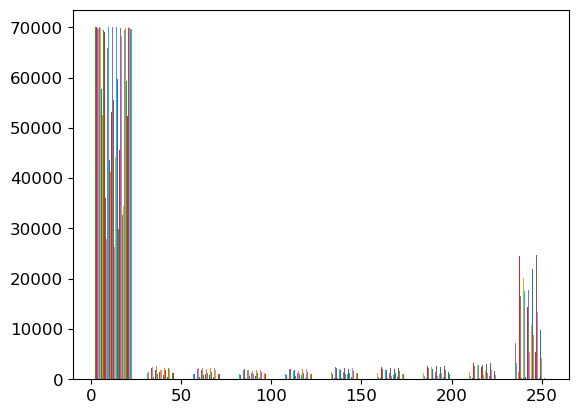

In [10]:
plt.hist(X)
plt.show()

- The $70,000$ instances of ‘data’ are tables, each containing $28^2$ values, which have clearly shades of grey between $0$ (white) and $255$ (black). 
- ‘target’ is also a one-dimensional table with a length of $70,000$.

We can use the function [‘imshow’](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html) from ‘matplotlib’ to display the corresponding image.

Saving figure some_digit_plot


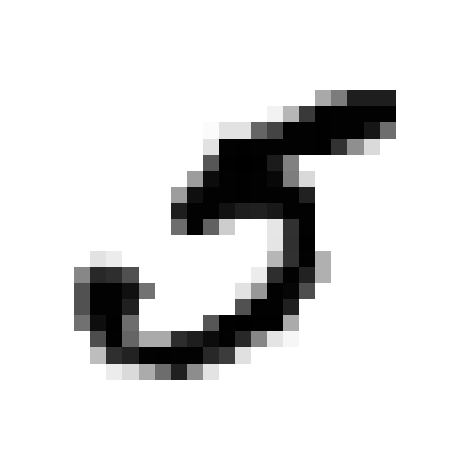

In [11]:
%matplotlib inline 
import matplotlib 
import matplotlib.pyplot as plt 

some_digit_image = some_digit.reshape(28, 28) 
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, 
 interpolation="nearest") 
plt.axis("off") 

save_fig("some_digit_plot") 
plt.show()

The image looks like a handwritten 5. Let’s check if it’s indeed labelled as such.

In [11]:
y[36000]

5.0

Assuming that we’ll often need to observe our data as an image, we define a function for this purpose:

In [113]:
def plot_digit(data):
    data = data.reshape(28, 28) 
    plt.imshow( data, cmap = matplotlib.cm.binary, 
    interpolation="nearest") 
    plt.axis("off") 

    save_fig("data") 
    plt.show()

As a bonus, we’ll plot some data samples on a matrix:

In [13]:
def plot_digits(instances, images_per_row=10, **options): 
   size = 28 
   images_per_row = min(len(instances), images_per_row) 
   images = [instance.reshape(size,size) for instance in instances] 
   n_rows = (len(instances) - 1) // images_per_row + 1 
   row_images = [] 
   n_empty = n_rows * images_per_row - len(instances) 
   images.append(np.zeros((size, size * n_empty))) 
   for row in range(n_rows): 
      rimages = images[row * images_per_row: (row + 1) * images_per_row] 
      row_images.append(np.concatenate(rimages, axis=1)) 
      image = np.concatenate(row_images, axis=0) 
   plt.imshow(image, cmap = matplotlib.cm.binary, **options) 
   plt.axis("off")

Saving figure more_digits_plot


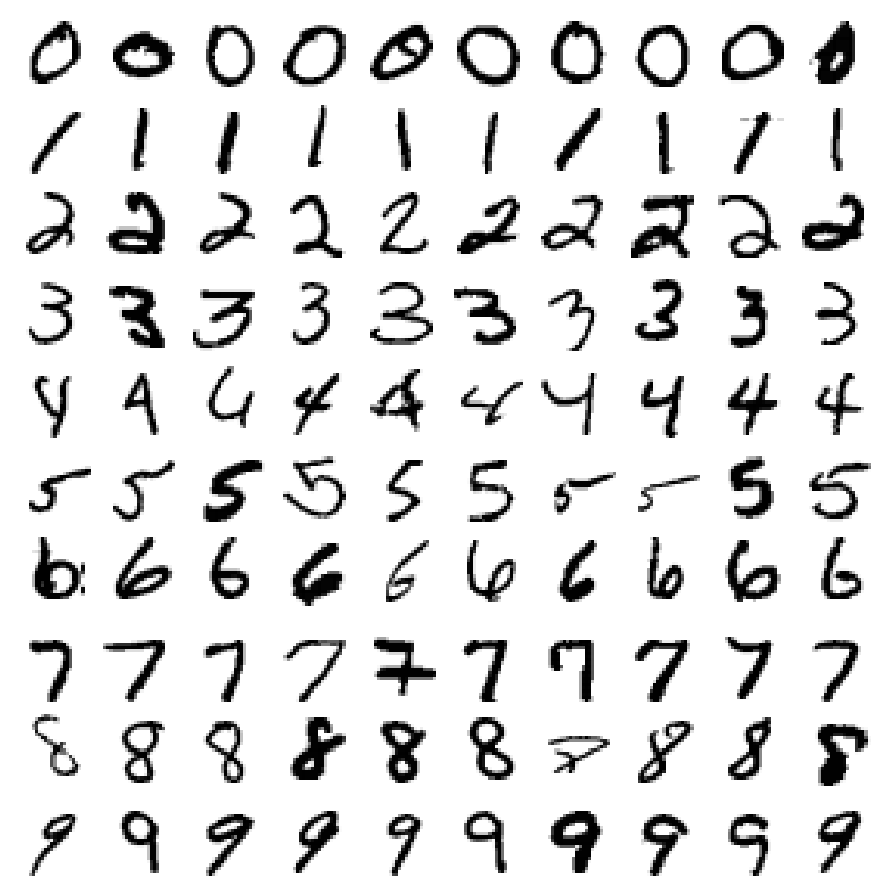

In [20]:
plt.figure(figsize=(9,9)) 
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]] 
plot_digits(example_images, images_per_row=10) 
save_fig("more_digits_plot") 
plt.show()

## Creating the testing set and the training set

Are we already falling into the _data snooping_ trap? In any case, it would be about time to create a testing dataset if ‘mnist’ wasn’t already split into a training set and a testing set.

In [14]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The _dataset_ looks sorted. We’ll shuffle the data to avoid influencing our algorithms. 

&gt; **Note**: Shuffling a dataset is a good thing here, as we don’t want the algorithms to be able to learn from the position of an image in the _dataset_. This would be a very bad idea if our dataset were a time series.

In [15]:
import numpy as np 

shuffle_index = np.random.permutation(60000) 
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a binary classifier

This is the first _classification_ exercise for us. We’ll first simplify the problem by creating a _binary classifier_ that will predict whether the digit represented by an instance _is a $5$_ or _is not a $5$_. To do this, we create two new sets of labels (‘y_train_5’ and ‘y_test_5’) with Boolean values from the old ones:

In [16]:
y_train_5 = (y_train == 5) 
y_test_5 = (y_test == 5)

To begin with, we’ll train a classifier by [_stochastic gradient descent_](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) using the [‘SGDClassifier’](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) from ‘scikit-learn’. The main advantage of this algorithm is that it processes each instance independently, so it’s particularly suitable for _online_ learning. Let’s create it and train it on the training set.

In [17]:
from sklearn.linear_model import SGDClassifier 

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train)
#CODE TO BE COMPLETED # Model training

c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(max_iter=5, random_state=42)

Our model is now ready to predict:

In [20]:
sgd_clf.predict([some_digit])

array([5.])

Our number is indeed a $5$. The prediction is valid. However, we need to measure our model’s performance more accurately.

## Measuring performance

### _Cross-validation_

As we’ve done several times in the _workshop_ on the _pipeline ML_, we’re going to _cross_-validate our model. Below, we carry out this work _by hand_ in order to emphasise the need to stratify our dataset cut-out. All classes (‘True’ and ‘False’) must be represented in similar proportions from one _fold_ to the next. We then perform the same operation with the [‘cross_val_score’](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) from ‘scikit-learn’, which also uses stratification.

In [21]:
# cross-val a la mano 
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone 

skfolds = StratifiedKFold(n_splits=3, random_state=None) 

for train_index, test_index in skfolds.split(X_train, y_train_5): 
 clone_clf = clone(sgd_clf) 
 X_train_folds = X_train[train_index] 
 y_train_folds = (y_train_5[train_index]) 
 X_test_fold = X_train[test_index] 
 y_test_fold = (y_train_5[test_index]) 

 clone_clf.fit(X_train_folds, y_train_folds) 
 y_pred = clone_clf.predict(X_test_fold) 
 n_correct = sum(y_pred == y_test_fold) 
 print(n_correct / len(y_pred)) 



c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.96225


c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.9645
0.94765


c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [22]:
# ⨯-val with scikit-learn 
from sklearn.model_selection import cross_val_score 
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.96225, 0.9645 , 0.94765])

95 %! This is encouraging. Now let’s compare this result to that of an absurd classifier which classifies all instances offered to it as ‘not 5’. 

First, we need to create the classifier:

In [23]:
from sklearn.base import BaseEstimator 
class Never5Classifier(BaseEstimator): 
 def fit(self, X, y=None): 
    pass
 #CODE TO BE COMPLETED 
 def predict(self, X):
   return np.zeros((len(X), 1), dtype=bool)
 #CODE TO BE COMPLETED

Then we have to _cross_-validate one instance:

In [24]:
never_5_clf = Never5Classifier() 
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
#CODE TO BE COMPLETED

array([0.909  , 0.90715, 0.9128 ])

Our classifier seems only slightly better than a trivial classifier. What we can conclude, first of all, is that this _accuracy_ measure is not the right metric for the classifier of a [_skewed_](https://en.wikipedia.org/wiki/Skewness)-_dataset_.

### Confusion matrix 

The [_confusion matrix_](https://en.wikipedia.org/wiki/Confusion_matrix) is a key tool when it comes to studying the performance of a supervised classification system. Take the time to read the article provided in the link. 

Here’s what a confusion matrix looks like in general: 

|_label_|classified as $1$|classified as $2$|classified as $3$|...|classified as $n$| 
|---|---|---|---|---|---| 
|**$1$**|**$1$ classified as $1$**|_$1$ classified as $2$_|_$1$ classified as $3$_|...|_$1$ classified as $n$_| 
|**$2$**|_$2$ classified as $1$_|**$2$ classified as $2$**|_$2$ classified as $3$_|...|_$2$ classified as $n$_| 
|**$3$**|_$3$ classified as $1$_|_$3$ classified as $2$_|**$3$ classified as $3$**|...|_$3$ classified as $n$_| 
|...|...|...|...|...|...| 
|**$n$**|_$n$ classified as $1$_|_$n$ classified as $2$_|_$n$ classified as $3$_|...|**$n$ classified as $n$**| 

Then in the binary case: 

|_label_|classé FAUX|classé VRAI| 
|---|---|---| 
|**FAUX**|**vrai NEGATIF**|_faux POSITIF_| 
|**VRAI**|_faux NEGATIF_|**vrai POSITIF**| 

We’ll try to calculate this matrix for our classifier. 

|_label_|classified as ‘not 5’|classified as ‘5’| 
|---|---|---| 
|‘not 5’|**true NEGATIVE**|_false POSITIVE_| 
|‘5’|_faux NEGATIF_|**vrai POSITIF**| 

To do this, we use [‘cross_val_predict’](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html). This function is used to obtain, for each _fold_ in the training set, the predictions obtained by learning from the rest of the data.

In [25]:
from sklearn.model_selection import cross_val_predict 
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


We can now calculate the confusion matrix with [‘confusion_matrix’](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

In [26]:
from sklearn.metrics import confusion_matrix 
confusion_matrix(y_train_5, y_train_pred)

array([[53417,  1162],
       [ 1350,  4071]], dtype=int64)

Below, we can compare it to the confusion matrix that would be produced by a perfect classifier:

In [27]:
y_train_perfect_predictions = y_train_5 
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

The confusion matrix is packed with information, but we have developed the habit of trying to obtain a score. It’s a common practice to look at _precision_ on the one hand and _recall_ on the other hand for a binary classifier. 

$$ 
\newcommand\TP{\mbox{TP}} 
\newcommand\TN{\mbox{TN}} 
\newcommand\FP{\mbox{FP}} 
\newcommand\FN{\mbox{FN}} 
\newcommand\precision{\mbox{precision}} 
\newcommand\recall{\mbox{recall}} 
$$ 

The function _precision_ is _accuracy_ for positive predictions: 

$$ 
\precision = \frac{\TP}{\TP+\FP} 
$$ 

The function _recall_ is _ratio_ for correctly classified positive results: 

$$ 
\recall = \frac{\TP}{\TP+\FN} 
$$ 

It would be easy to trivially obtain perfect classifiers for either of these metrics. Therefore, they are of little relevance if considered individually. On the other hand, trying to cover these two indicators at the same time is a good strategy.

### Precision and _recall_ 

We can calculate _precision_ and _recall_ using ‘scikit-learn’:

In [29]:
from sklearn.metrics import precision_score, recall_score 
precision_score(y_train_5, y_train_pred)

0.7779476399770686

In [1]:
#CODE TO BE COMPLETED # score check
precision_score = 1

In [30]:
recall_score(y_train_5, y_train_pred)

0.7509684560044272

In [2]:
recall_score = 1

Let’s face it, when our _5-classifier_ says that a number is a 5, it’s only right 77% of the time. What’s more, it only detects 80% of all 5s. We were right not to get too excited about the 95% accuracy! 

It’s common to use the [_harmonic mean_](https://en.wikipedia.org/wiki/Harmonic_mean) of _precision_ and _recall_ as a _unified_ metric. The harmonic mean has the advantage of assigning a lot of weight to low values, which means that a high score is only possible if the two basic measures are high. This score is called $F_1-score$. 

$$ 
F_1 = \frac{2}{\frac{1}{\precision}+\frac{1}{\recall}} = 2 \times \frac{\precision \times \recall}{\precision + \recall} = \frac{\TP}{\TP+\frac{\FN+\FP}{2}} 
$$ 

It can be calculated effortlessly with ‘scikit-learn’.

In [31]:
from sklearn.metrics import f1_score 
#CODE TO BE COMPLETED
f1_score(y_train_5, y_train_pred)

0.7642200112633752

The $F_1$-score gives preference to having a _precision_ and a _recall_ close to each other. That said, the indicator must be chosen according to the objective. For example, a detector of content suitable for children is more likely to produce false negatives than false positives (low _recall_ and high _precision_). We have to find the right _precision/recall tradeoff_.

To achieve this, we look at how the ‘SGDClassifier’ makes its decisions. A _decision function_ calculates a score for each instance. If this score exceeds a given threshold (_threshold_), the instance is assigned a positive label. We can adjust the value of this threshold to establish this balance. 

‘Scikit-learn’ does not provide access to this threshold but we can call the decision function.

In [32]:
y_scores = sgd_clf.decision_function([some_digit]) 
y_scores

array([[-152619.46799791, -441052.22074349, -249930.3138537 ,
        -237258.35168498, -447251.81933158,  120565.05820991,
        -834139.15404835, -188142.48490477, -555223.79499145,
        -536978.92518594]])

In [34]:
threshold = 0 # default threshold for the classifier 
y_some_digit_pred = (y_scores > threshold) 
y_some_digit_pred

array([[False, False, False, False, False,  True, False, False, False,
        False]])

In [35]:
threshold = 200000 
y_some_digit_pred = (y_scores > threshold) 
y_some_digit_pred

array([[False, False, False, False, False, False, False, False, False,
        False]])

With this kind of threshold, the number is no longer recognized as ‘5’. We could honestly believe that raising the threshold will lower _recall_. How do we choose this threshold? First of all, we’ll calculate (_using_ ‘cross_val_predict’) the results of the decision function for our entire training set.

In [36]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
 method="decision_function")

c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [37]:
y_scores.shape

(60000,)

This is an opportunity to check if the previous predictions had indeed been calculated with a threshold equal to zero:

In [49]:
#CODE TO BE COMPLETED # is the threshold set to zero? 
threshold = 0;
y_some_digit_pred = (y_scores > threshold);

print(len(y_scores));
print([i for i in y_some_digit_pred if i] );
print('threshold is != 0');


60000
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

We can now calculate the functions _precision_ and _recall_ for all possible thresholds. We’ll use [‘precision_recall_curve’](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html)

In [38]:
from sklearn.metrics import precision_recall_curve 
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


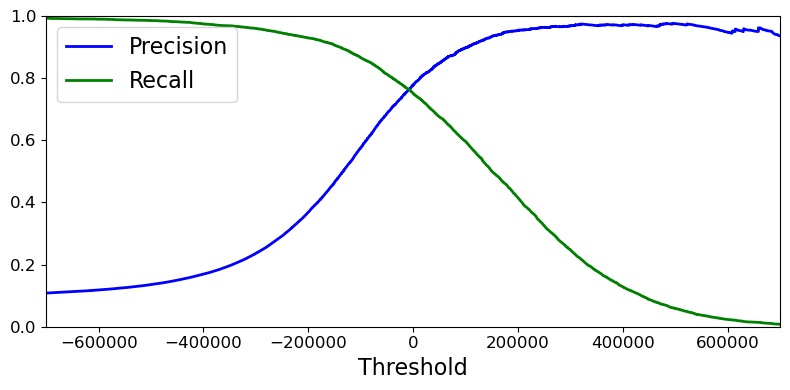

In [39]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
 plt.plot(thresholds, precisions[:-1], "b-", label="Precision", linewidth=2) 
 plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2) 
 plt.xlabel("Threshold", fontsize=16) 
 plt.legend(loc="upper left", fontsize=16) 
 plt.ylim([0, 1]) 

plt.figure(figsize=(8, 4)) 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds) 
plt.xlim([-700000, 700000]) 
save_fig("precision_recall_vs_threshold_plot") 
plt.show()

This graph allows us to set the threshold according to the compromise we want to achieve. 

Another approach is to graphically compare _precision_ and _recall_.

Saving figure precision_vs_recall_plot


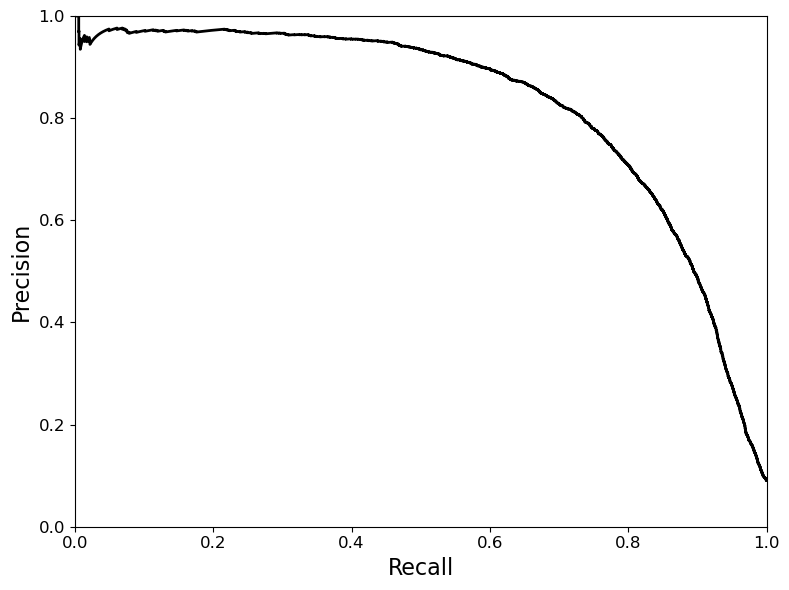

In [40]:
def plot_precision_vs_recall(precisions, recalls): 
 plt.plot(recalls, precisions, "k-", linewidth=2) 
 plt.xlabel("Recall", fontsize=16) 
 plt.ylabel("Precision", fontsize=16) 
 plt.axis([0, 1, 0, 1]) 

plt.figure(figsize=(8, 6)) 
plot_precision_vs_recall(precisions, recalls) 
save_fig("precision_vs_recall_plot") 
plt.show()

We see that there is a significant drop in _precison_ to around 75% of _recall_. Depending on the project, it may be wise to choose a threshold that ensures a _recall_ below this value. 

Let’s say we’re aiming for a _precision_ of around 90%. We can set the threshold using our graphs:

In [50]:
y_train_pred_90 = (y_scores > 700000) 

precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(0.9347826086956522, 0.00793211584578491)

An arbitrarily high precision classifier can be obtained by adjusting the threshold. The question to ask ourselves systematically is the impact on _recall_.

### ROC curve 

The [_ROC curve_](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is another way to evaluate a binary classifier. It compares the _true positive rate_ (_TPR_ or _recall_) with the [_false positive rate_](https://en.wikipedia.org/wiki/False_positive_rate) (_FPR_). 
$$ 
\newcommand\TPR{\mbox{TPR}} 
\newcommand\FPR{\mbox{FPR}} 
$$ 
We remember the _recall_ formula, or the _TPR_ formula: 
$$ 
\TPR = \frac{\TP}{\TP+\FN} 
$$ 
And the same goes for the _FPR_ formula: 
$$ 
\FPR = \frac{\FP}{\TN+\FP} 
$$ 
We’re going to try and build this curve.

In [42]:
from sklearn.metrics import roc_curve 

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


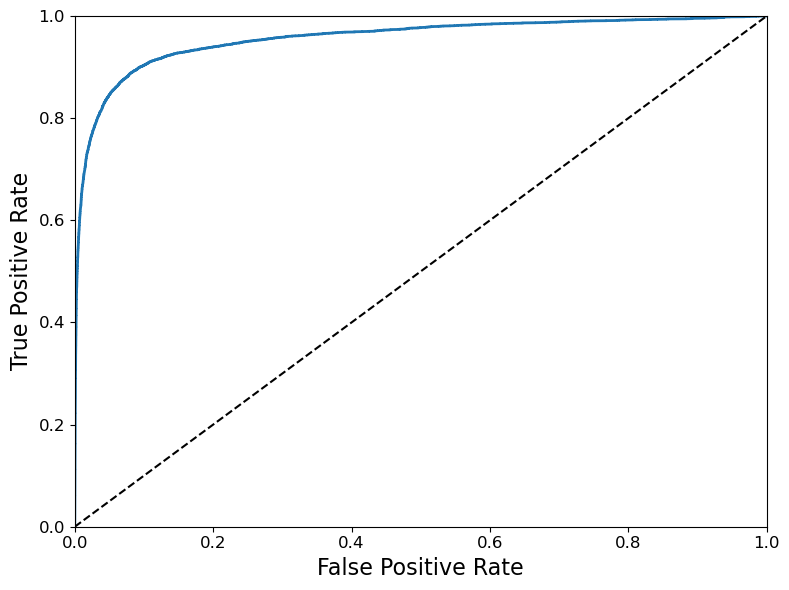

In [43]:
def plot_roc_curve(fpr, tpr, label=None): 
 plt.plot(fpr, tpr, linewidth=2, label=label) 
 plt.plot([0, 1], [0, 1], 'k--') 
 plt.axis([0, 1, 0, 1]) 
 plt.xlabel('False Positive Rate', fontsize=16) 
 plt.ylabel('True Positive Rate', fontsize=16) 

plt.figure(figsize=(8, 6)) 
plot_roc_curve(fpr, tpr) 
save_fig("roc_curve_plot") 
plt.show()

Once again, it’s a matter of compromise. A high rate of true positives implies many false positives. The dotted diagonal represents the ROC of a random classifier. An ideal classifier would deviate as far as possible from this by fitting the upper left corner. This is why we use the _air under the ROC curve_ as a comparison metric, which should be as close as possible to $1$. We’ll calculate it using [‘roc_auc_score’](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html).

In [56]:
#CODE TO BE COMPLETED 
from sklearn.metrics import roc_auc_score

#CODE TO BE COMPLETED
roc_auc_score(y_train_5, y_scores)

0.9562435587387078

&gt; **Note**: the _precision_ / _recall_ curve is a better indicator when positives are rare or when we seek to avoid false positives. The _ROC_ curve is to be preferred in all other cases.

## Comparison between two models

### _random forest classifier_ 

We want to compare our model with a _random forest classifier_. Please note that this model does not provide the user with a ‘decision_function()’, but rather a ‘predict_proba()’ function that returns a list of probabilities for each class and for each instance. Most classifiers have either one or the other of these functions. 

We’ll use ‘predict_proba()’ to build a _ROC_ curve.

In [57]:
from sklearn.ensemble import RandomForestClassifier 
forest_clf = RandomForestClassifier(random_state=42, n_estimators=10) 
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba" )
 #CODE TO BE COMPLETED

In [58]:
y_probas_forest

array([[1. , 0. ],
       [0.9, 0.1],
       [1. , 0. ],
       ...,
       [1. , 0. ],
       [1. , 0. ],
       [1. , 0. ]])

We now need to calculate a score. We’ll consider the probability of the positive class (second column) and then apply ‘roc_curve’.

In [62]:
#CODE TO BE COMPLETED 
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

We can now compare our curves:

Saving figure roc_curve_comparison_plot


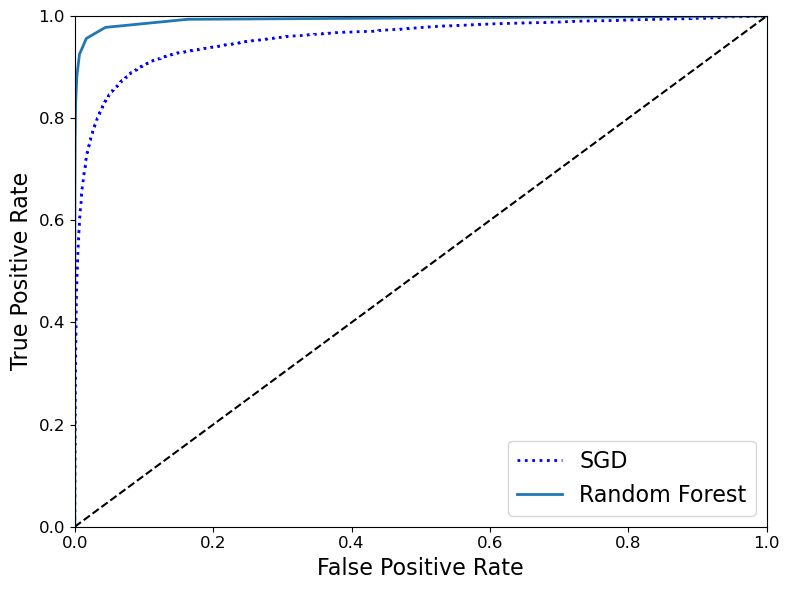

In [63]:
plt.figure(figsize=(8, 6)) 
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD") 
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest") 
plt.legend(loc="lower right", fontsize=16) 
save_fig("roc_curve_comparison_plot") 
plt.show()

We’re much closer to the corner, which is promising. Let’s calculate the _AUC_:

In [64]:
#CODE TO BE COMPLETED
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

It’s still a nice score. We’ll see that _precision_ and _recall_ are not bad either: 

In [66]:
#CODE TO BE COMPLETED #cross_val_predict 
a = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
#CODE TO BE COMPLETED #precision

precision_score(y_train_5, a)

0.9852973447443494

In [70]:
#CODE TO BE COMPLETED #recall
recall_score(y_train_5, a)

0.8282604685482383

We now know how to train and evaluate binary classifiers. It’s time to switch to multiclass!

## Multiclass classification

There are algorithms that are multiclass by nature, such as random forests or Bayesian classifiers. For the rest (_SVM_, _linear classifiers_, _etc_), a strategy is to use one _classifier_ per class and to choose the one with the highest score. This is the _one-versus-all_ (_OvA_) strategy. 

Another strategy is to build a binary _classifier_ for any pair of classes (which differentiates between ‘1’ and ‘4’, ‘7’ and ‘2’, _etc_.) This is the _one-versus-one_ (_OvO_) strategy. For $n$ classes, we will train $\frac{n \times (n-1)}{2}$ classifiers. Or $45$ for _MNIST_. It’s a lot, but all you have to do is train them on the subpart of the dataset corresponding to the classes to be differentiated. This strategy is well suited to algorithms that scale poorly to large datasets (like _SVM_). 

On the other hand, for most binary classification algorithms, we’ll prefer _OvA_ (by default with Scikit-learn except for SVM). 

### _OvA_ strategy 

Let’s try it with our ‘SGCDClassifier’:

In [67]:
sgd_clf.fit(X_train, y_train) # y_train AND NOT y_train_5 
sgd_clf.predict([some_digit])

c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([5.])

Easy. The ‘fit()’ function applied an _OvA_ strategy. And the prediction is good. 

To confirm this, we can call the decision function and simulate the prediction:

In [68]:
some_digit_scores = sgd_clf.decision_function([some_digit]) 
some_digit_scores

array([[-152619.46799791, -441052.22074349, -249930.3138537 ,
        -237258.35168498, -447251.81933158,  120565.05820991,
        -834139.15404835, -188142.48490477, -555223.79499145,
        -536978.92518594]])

In [71]:
class_max_index = np.argmax(some_digit_scores) 
class_max_index

5

In [72]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [73]:
sgd_clf.classes_[class_max_index]

5.0

### _OvO_ strategy 

Now let’s try the second strategy:

In [74]:
from sklearn.multiclass import OneVsOneClassifier 
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42)) 
ovo_clf.fit(X_train, y_train) 
ovo_clf.predict([some_digit])

c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_mo

array([5.])

In [75]:
len(ovo_clf.estimators_)

45

### Random forest 

There’s no _OvA_ or _OvO_ for this intrinsically multiclass algorithm.

In [76]:
forest_clf.fit(X_train, y_train) 
forest_clf.predict([some_digit])

array([5.])

In [77]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

Not bad. 80% chance of getting a $5$.

### Cross-validation

Let’s evaluate a model using _cross-validation_.

In [78]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.8618, 0.8675, 0.8389])

It’s not bad (given that a random classifier would have approximately 10% _accuracy_. 
We can try _scaling_ (as in the previous _workshops_) to improve the solution.

In [79]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64)) 
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.9091 , 0.90955, 0.9062 ])

This is real progress that we can measure.

### Error analysis

Let’s say that, after benchmarking and fine-tuning, we want to analyse the errors made by a model. Let’s display the confusion matrix:

In [80]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3) 
conf_mx = confusion_matrix(y_train, y_train_pred) 
conf_mx

c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\junio\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([[5728,    3,   18,   10,   11,   48,   54,   10,   38,    3],
       [   2, 6472,   43,   27,    6,   41,    6,    9,  124,   12],
       [  59,   39, 5300,  103,   96,   24,   99,   57,  167,   14],
       [  60,   42,  133, 5357,    4,  213,   35,   52,  135,  100],
       [  14,   28,   33,    9, 5366,    8,   56,   33,   88,  207],
       [  68,   49,   30,  197,   76, 4566,  118,   33,  190,   94],
       [  35,   28,   31,    1,   47,   86, 5639,    9,   42,    0],
       [  22,   20,   70,   29,   65,   11,    6, 5789,   18,  235],
       [  55,  158,   63,  157,   11,  155,   61,   24, 5022,  145],
       [  38,   37,   30,   85,  185,   24,    2,  216,   74, 5258]],
      dtype=int64)

It’s a bit stodgy. Your eyes probably prefers images (or even colours).

Saving figure confusion_matrix_plot


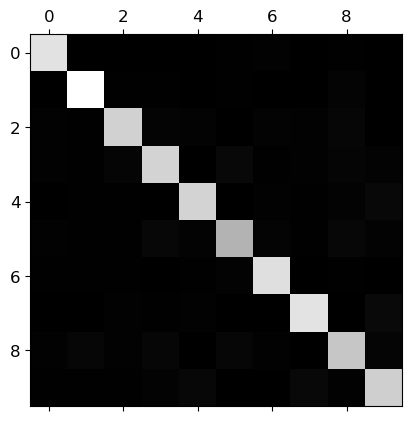

In [81]:
plt.matshow(conf_mx, cmap=plt.cm.gray) 
save_fig("confusion_matrix_plot", tight_layout=False) 
plt.show()

As an exercise, use [‘matshow’]](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.matshow.html) to add some colour to this matrix viewing:

In [85]:
def plot_confusion_matrix(matrix): 
   fig = plt.figure(figsize=(8,8))  
   ax = fig.add_subplot(111) 
   cax = ax.matshow(matrix) 
   fig.colorbar(cax) 
   

plot_confusion_matrix(conf_mx)

Everything looks okay. The diagonal is populated and the rest is less so. Class ‘5’ is slightly darker. This may mean that the classification is not as good or simply that the dataset contains less than 5. 

We’ll try to highlight the errors by dividing each value by the number of images in the corresponding class. It will be easier to compare rates rather than quantities.

In [86]:
row_sums = conf_mx.sum(axis=1, keepdims=True) 
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


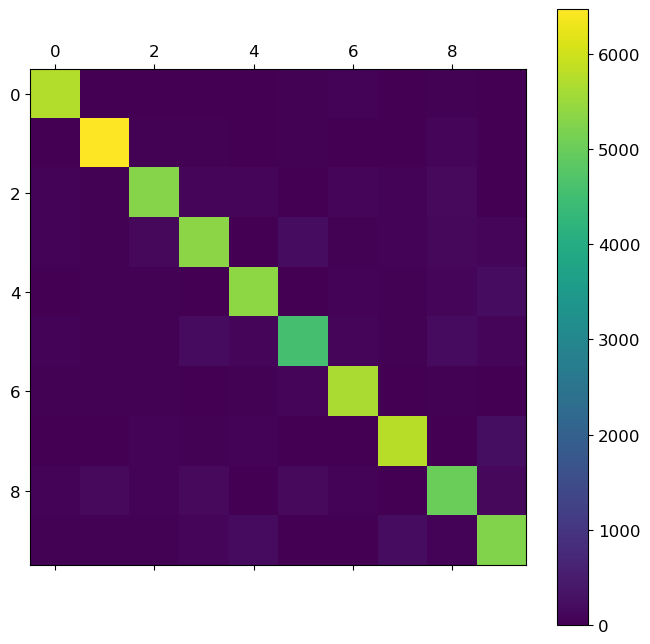

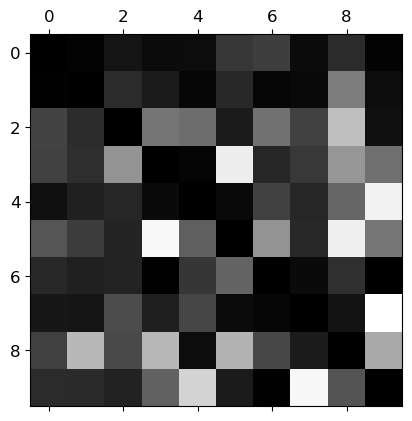

In [87]:
np.fill_diagonal(norm_conf_mx, 0) 
plt.matshow(norm_conf_mx, cmap=plt.cm.gray) 
save_fig("confusion_matrix_errors_plot", tight_layout=False) 
plt.show()

In [88]:
plot_confusion_matrix(norm_conf_mx)

It’s clearer. We now have a much clearer view of the errors that were made. For example, the column for class ‘8’ is quite clear, as we know that many images are mistakenly considered to be 8s. 

We also see that many 3s are classified in class ‘5’. This encourages us to display part of the elements within classes ‘3’ and ‘5’ in the confusion matrix configuration.

Saving figure error_analysis_digits_plot


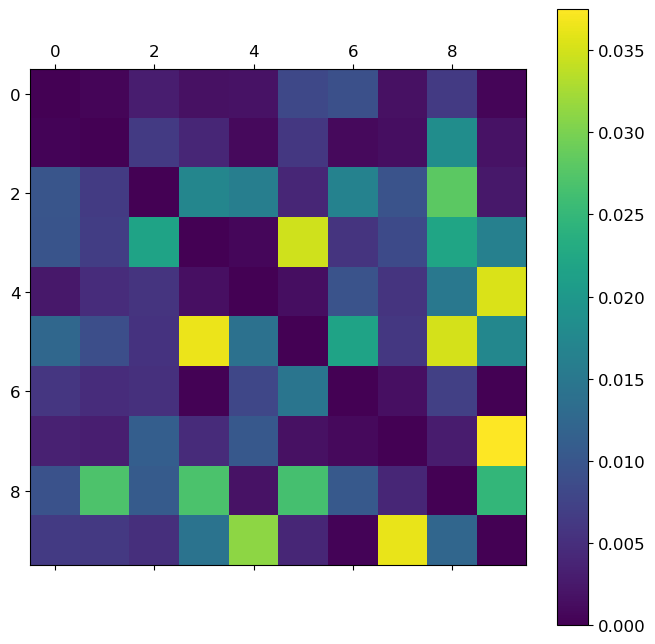

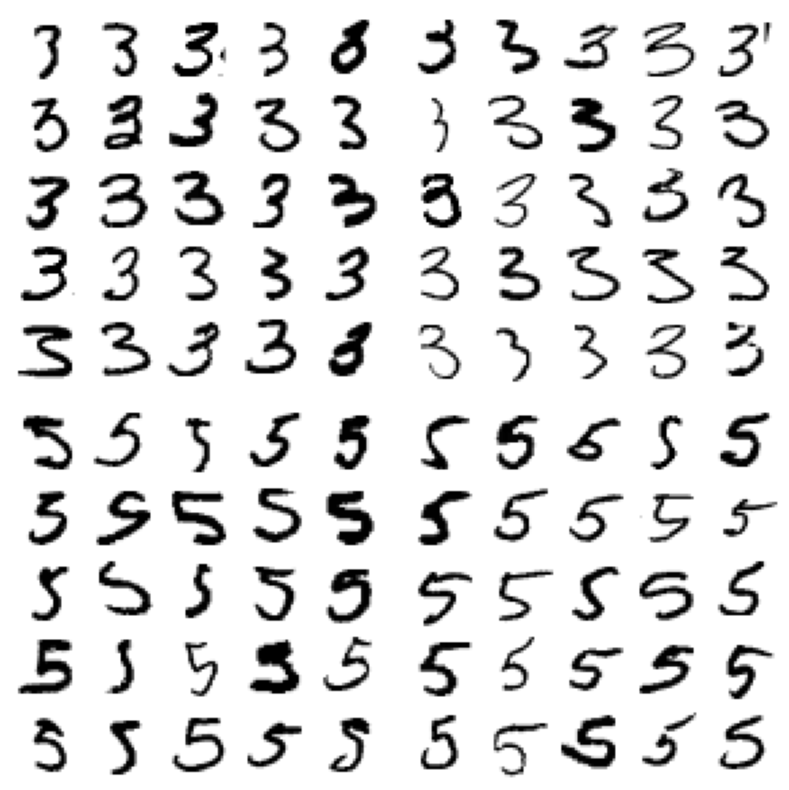

In [90]:
cl_a, cl_b = 3, 5 
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] 
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] 
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] 
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] 

plt.figure(figsize=(8,8)) 
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5) 
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5) 
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5) 
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5) 
save_fig("error_analysis_digits_plot") 
plt.show()

Observing these images encourages us to consider new strategies: 
- We use a linear algorithm that assigns a weight to each pixel. That doesn’t make up for some minor flaws. 
- We could use a preprocessing method (centring, rotation, _etc_) to make learning easier. 
- _etc_. 



## Multilabel classification 

There may be a need to assign several labels to the same instance. We can imagine a facial recognition algorithm recognising 5 people in the same picture. Today, we’ll just create a model that decides whether a handwritten number is greater than or equal to 7 (‘large’) and odd (‘odd’).

In [92]:
from sklearn.neighbors import KNeighborsClassifier 

#CODE TO BE COMPLETED # We are building y_train_large from y_train
y_train_large = (y_train >= 7)
y_train_odd = (y_train %2==1)
#CODE TO BE COMPLETED # The same goes for y_train_odd 
y_multilabel = np.c_[y_train_large, y_train_odd] 

knn_clf = KNeighborsClassifier() 
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [93]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [94]:
# ATTENTION: this calculation will take time (hours) depending on the hardware 
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1) 
f1_score(y_multilabel, y_train_knn_pred, average="macro") # average="weighted" if classes are unbalanced 

# result: 0.977 approx.

0.9770907847752499

## Multi-output classification 

We’ll create a new dataset from the previous one. We’ll randomly generate noise on the images to obtain _dirty_ images, then we’ll consider the original images as _target_ for our learning.

In [95]:
# We generate noise on the images: 
noise = np.random.randint(0, 100, (len(X_train), 784)) 
X_train_mod = X_train + noise 
noise = np.random.randint(0, 100, (len(X_test), 784)) 
X_test_mod = X_test + noise 
y_train_mod = X_train 
y_test_mod = X_test

Saving figure data


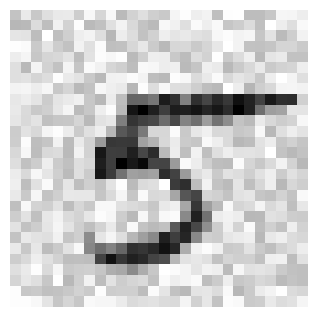

Saving figure data


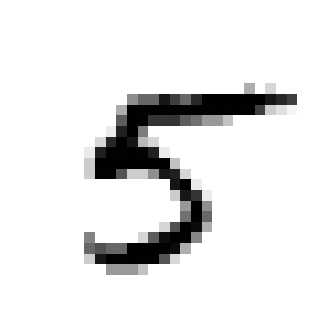

Saving figure noisy_digit_example_plot


<Figure size 640x480 with 0 Axes>

In [96]:
some_index = 5500 
plt.subplot(121); plot_digit(X_test_mod[some_index]) 
plt.subplot(122); plot_digit(y_test_mod[some_index]) 
save_fig("noisy_digit_example_plot") 
plt.show()

We can now train a model (here [$k$-nearest_neighbors_algorithm_](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)) to clean our images. We use an image from the testing set as an example.

In [97]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

Saving figure data


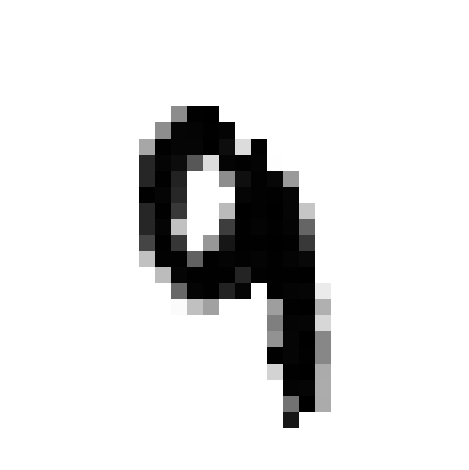

Saving figure cleaned_digit_example_plot


In [105]:
#CODE TO BE COMPLETED # Cleaning is predicting 
clean_digit = knn_clf.predict([X_test_mod[5000]])
plot_digit(clean_digit) 
save_fig("cleaned_digit_example_plot")

Saving figure data


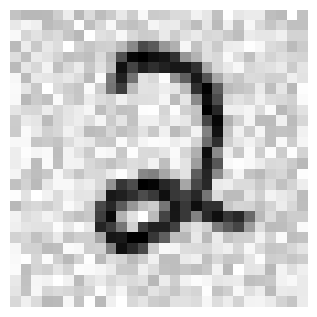

Saving figure data


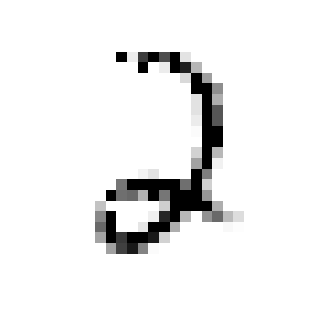

In [115]:
other_index = 2312 
#CODE TO BE COMPLETED # Cleaning is predicting 
clean_digit = knn_clf.predict([X_test_mod[other_index]])
plt.subplot(121); plot_digit(X_test_mod[other_index]) 
plt.subplot(122); plot_digit(clean_digit)

The result is quite convincing!